# Cartpole with pixels

In [1]:
# Numpy
import random
import numpy as np

# Miscellaneous
import glob
import io
import base64
import os
from tqdm.notebook import tqdm

# Visualization
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import matplotlib.pyplot as plt

# Neural network
from torch import nn
import torch

# Reinforcement learning
from collections import deque # this python module implements exactly what we need for the replay memeory
import gym

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [3]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

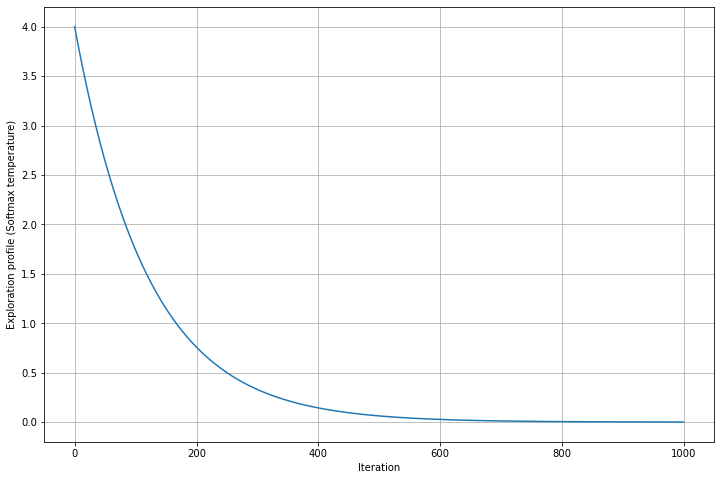

In [4]:
#### Define exploration profile
initial_value = 4
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

plt.show()

In [5]:
def get_screen(env):
    ''' Extract one step of the simulation.'''
    rgb_weights = [0.2989, 0.5870, 0.1140]
    # Get RGB
    # Images are 600x400 pixels
    screen = env.render(mode='rgb_array')#.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    # Convert to Grayscale (colors are not important)
    screen = np.dot(screen[..., :3], rgb_weights)
    # Dimensionality reduction
    screen = screen[150:320, 200:400]
    return screen[np.newaxis, :]

def from_screen_to_tens(screen):
    return torch.tensor(screen).type(torch.float).unsqueeze(0)

In [6]:
class Conv_DQN(nn.Module):

    def __init__(self, action_space_dim):
        super().__init__()
    
        self.conv = nn.Sequential( # 600x400
                                    nn.Conv2d(4, 8, kernel_size=9, padding=0, stride=4), 
                                    nn.ReLU(),
                                    # Second convolutional layer
                                    nn.Conv2d(8, 16, kernel_size=6, padding=0, stride=4), 
                                    nn.ReLU(),
                                    # Third convolutional layer
                                    nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=4),
                                    nn.ReLU(),
                                    # Flatten layer
                                    nn.Flatten(start_dim=1),
                
                )
        
        self.linear = nn.Sequential(
                nn.Linear(288, 250),
                nn.Tanh(),
                nn.Linear(250, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        x = self.linear(x)
        return x

In [7]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
action_space_dim = 2

### PARAMETERS
gamma = 0.95   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 0.022   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = Conv_DQN(action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = Conv_DQN(action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [14]:
def choose_action_softmax(net, state, temperature):
    state = state.to(device)
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state).squeeze(0)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.cpu() / temperature, dim=0).numpy()
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    # Create tensors for each element of the batch
    states  = np.array( [s[0] for s in batch], dtype=np.float32 )
    states = torch.from_numpy(states)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states =  np.array([s[2] for s in batch if s[2] is not None], dtype=np.float32)# the next state can be None if the game has ended
    non_final_next_states = torch.from_numpy(non_final_next_states)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)
    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states.to(device)).cpu()
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape
    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [9]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

ml = 3

training_score = []
obs_history = deque(maxlen=ml)

training_dataset = []

for i in range(ml): obs_history.append(np.zeros((1, 170, 200) ))

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    # Reset the environment and get the initial state
    state = env.reset()
    obs = get_screen(env)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off
    for i in range(ml):
        obs = np.append( obs, obs_history[-i-1], axis=0)
    st = 0
    while not done:
        # Adding history
        for i in range(ml):
            if obs_history[i] is None: obs_history[i] = np.zeros((1, 170, 200) )
        #obs += 0.5*obs_history[0]
        obs_history.append(obs[0][np.newaxis, :])
        
        if st > 4:
            # state, label
            training_dataset.append( (obs, state) )
        
        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, from_screen_to_tens(obs), temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_obs = get_screen(env)
        
        for i in range(ml):
            next_obs = np.append( next_obs, obs_history[-i-1], axis=0) 
        
        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1
        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_obs = None

        # Update the replay memory
        replay_mem.push(obs, action, next_obs, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Set the current state for the next iteration
        obs = next_obs
        state = next_state
        st += 1

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    training_score.append(score)
env.close()

<ipython-input-8-e7d6304cbb8e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 3.869105318455729
Updating target network...
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 3.7114939058851326
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 3.5603029

EPISODE: 120 - FINAL SCORE: 23 - Temperature: 1.4865829844310245
Updating target network...
EPISODE: 121 - FINAL SCORE: 54 - Temperature: 1.4742692172911107
EPISODE: 122 - FINAL SCORE: 17 - Temperature: 1.4620574484000428
EPISODE: 123 - FINAL SCORE: 45 - Temperature: 1.4499468328788614
EPISODE: 124 - FINAL SCORE: 35 - Temperature: 1.4379365328469669
EPISODE: 125 - FINAL SCORE: 10 - Temperature: 1.4260257173641504
Updating target network...
EPISODE: 126 - FINAL SCORE: 25 - Temperature: 1.4142135623731047
EPISODE: 127 - FINAL SCORE: 11 - Temperature: 1.4024992506424108
EPISODE: 128 - FINAL SCORE: 12 - Temperature: 1.3908819717099976
EPISODE: 129 - FINAL SCORE: 11 - Temperature: 1.3793609218270702
EPISODE: 130 - FINAL SCORE: 34 - Temperature: 1.3679353039025004
Updating target network...
EPISODE: 131 - FINAL SCORE: 11 - Temperature: 1.3566043274476813
EPISODE: 132 - FINAL SCORE: 19 - Temperature: 1.3453672085218358
EPISODE: 133 - FINAL SCORE: 32 - Temperature: 1.3342231696777787
EPISODE: 

EPISODE: 237 - FINAL SCORE: 40 - Temperature: 0.5617499515158296
EPISODE: 238 - FINAL SCORE: 10 - Temperature: 0.5570968254096733
EPISODE: 239 - FINAL SCORE: 13 - Temperature: 0.5524822423999629
EPISODE: 240 - FINAL SCORE: 22 - Temperature: 0.5479058832238526
Updating target network...
EPISODE: 241 - FINAL SCORE: 34 - Temperature: 0.5433674312630361
EPISODE: 242 - FINAL SCORE: 14 - Temperature: 0.5388665725218424
EPISODE: 243 - FINAL SCORE: 70 - Temperature: 0.534402995605511
EPISODE: 244 - FINAL SCORE: 16 - Temperature: 0.5299763916986479
EPISODE: 245 - FINAL SCORE: 13 - Temperature: 0.5255864545438602
Updating target network...
EPISODE: 246 - FINAL SCORE: 28 - Temperature: 0.5212328804205676
EPISODE: 247 - FINAL SCORE: 12 - Temperature: 0.5169153681239891
EPISODE: 248 - FINAL SCORE: 10 - Temperature: 0.5126336189443038
EPISODE: 249 - FINAL SCORE: 32 - Temperature: 0.5083873366459849
EPISODE: 250 - FINAL SCORE: 32 - Temperature: 0.5041762274473043
Updating target network...
EPISODE: 2

EPISODE: 353 - FINAL SCORE: 14 - Temperature: 0.2140470711366183
EPISODE: 354 - FINAL SCORE: 20 - Temperature: 0.212274061611714
EPISODE: 355 - FINAL SCORE: 19 - Temperature: 0.21051573840210802
Updating target network...
EPISODE: 356 - FINAL SCORE: 18 - Temperature: 0.20877197985709636
EPISODE: 357 - FINAL SCORE: 20 - Temperature: 0.2070426653336404
EPISODE: 358 - FINAL SCORE: 14 - Temperature: 0.20532767518802042
EPISODE: 359 - FINAL SCORE: 21 - Temperature: 0.20362689076755777
EPISODE: 360 - FINAL SCORE: 54 - Temperature: 0.20194019440240596
Updating target network...
EPISODE: 361 - FINAL SCORE: 43 - Temperature: 0.20026746939740941
EPISODE: 362 - FINAL SCORE: 12 - Temperature: 0.19860860002403005
EPISODE: 363 - FINAL SCORE: 32 - Temperature: 0.1969634715123404
EPISODE: 364 - FINAL SCORE: 28 - Temperature: 0.19533197004308317
EPISODE: 365 - FINAL SCORE: 8 - Temperature: 0.19371398273979668
Updating target network...
EPISODE: 366 - FINAL SCORE: 9 - Temperature: 0.19210939766100535
EP

EPISODE: 469 - FINAL SCORE: 47 - Temperature: 0.08155968423056191
EPISODE: 470 - FINAL SCORE: 35 - Temperature: 0.08088410340518039
Updating target network...
EPISODE: 471 - FINAL SCORE: 25 - Temperature: 0.08021411859768356
EPISODE: 472 - FINAL SCORE: 34 - Temperature: 0.07954968345474846
EPISODE: 473 - FINAL SCORE: 37 - Temperature: 0.07889075200700923
EPISODE: 474 - FINAL SCORE: 27 - Temperature: 0.07823727866587665
EPISODE: 475 - FINAL SCORE: 27 - Temperature: 0.077589218220384
Updating target network...
EPISODE: 476 - FINAL SCORE: 21 - Temperature: 0.07694652583405924
EPISODE: 477 - FINAL SCORE: 19 - Temperature: 0.07630915704182285
EPISODE: 478 - FINAL SCORE: 26 - Temperature: 0.07567706774691157
EPISODE: 479 - FINAL SCORE: 25 - Temperature: 0.07505021421782748
EPISODE: 480 - FINAL SCORE: 31 - Temperature: 0.07442855308531245
Updating target network...
EPISODE: 481 - FINAL SCORE: 33 - Temperature: 0.07381204133934757
EPISODE: 482 - FINAL SCORE: 21 - Temperature: 0.073200636326177

EPISODE: 584 - FINAL SCORE: 45 - Temperature: 0.031336763621909666
EPISODE: 585 - FINAL SCORE: 51 - Temperature: 0.03107719277103893
Updating target network...
EPISODE: 586 - FINAL SCORE: 30 - Temperature: 0.03081977201541845
EPISODE: 587 - FINAL SCORE: 33 - Temperature: 0.030564483545230323
EPISODE: 588 - FINAL SCORE: 34 - Temperature: 0.030311309698180175
EPISODE: 589 - FINAL SCORE: 51 - Temperature: 0.030060232958275167
EPISODE: 590 - FINAL SCORE: 32 - Temperature: 0.02981123595461214
Updating target network...
EPISODE: 591 - FINAL SCORE: 39 - Temperature: 0.029564301460175815
EPISODE: 592 - FINAL SCORE: 50 - Temperature: 0.02931941239064691
EPISODE: 593 - FINAL SCORE: 65 - Temperature: 0.02907655180322016
EPISODE: 594 - FINAL SCORE: 35 - Temperature: 0.028835702895432122
EPISODE: 595 - FINAL SCORE: 34 - Temperature: 0.02859684900399868
Updating target network...
EPISODE: 596 - FINAL SCORE: 54 - Temperature: 0.02835997360366219
EPISODE: 597 - FINAL SCORE: 33 - Temperature: 0.0281250

EPISODE: 698 - FINAL SCORE: 36 - Temperature: 0.01214073857475123
EPISODE: 699 - FINAL SCORE: 41 - Temperature: 0.012040173568100576
EPISODE: 700 - FINAL SCORE: 40 - Temperature: 0.011940441568478316
Updating target network...
EPISODE: 701 - FINAL SCORE: 42 - Temperature: 0.011841535675862934
EPISODE: 702 - FINAL SCORE: 70 - Temperature: 0.011743449047387654
EPISODE: 703 - FINAL SCORE: 51 - Temperature: 0.011646174896867008
EPISODE: 704 - FINAL SCORE: 54 - Temperature: 0.011549706494327329
EPISODE: 705 - FINAL SCORE: 55 - Temperature: 0.011454037165541133
Updating target network...
EPISODE: 706 - FINAL SCORE: 44 - Temperature: 0.011359160291565359
EPISODE: 707 - FINAL SCORE: 50 - Temperature: 0.011265069308283436
EPISODE: 708 - FINAL SCORE: 60 - Temperature: 0.011171757705951135
EPISODE: 709 - FINAL SCORE: 29 - Temperature: 0.011079219028746196
EPISODE: 710 - FINAL SCORE: 92 - Temperature: 0.010987446874321665
Updating target network...
EPISODE: 711 - FINAL SCORE: 72 - Temperature: 0.0

EPISODE: 812 - FINAL SCORE: 75 - Temperature: 0.004703661645435424
EPISODE: 813 - FINAL SCORE: 360 - Temperature: 0.00466469994951032
EPISODE: 814 - FINAL SCORE: 270 - Temperature: 0.004626060983803456
EPISODE: 815 - FINAL SCORE: 63 - Temperature: 0.004587742075053536
Updating target network...
EPISODE: 816 - FINAL SCORE: 63 - Temperature: 0.004549740572142606
EPISODE: 817 - FINAL SCORE: 67 - Temperature: 0.004512053845912637
EPISODE: 818 - FINAL SCORE: 109 - Temperature: 0.004474679288983623
EPISODE: 819 - FINAL SCORE: 71 - Temperature: 0.004437614315573189
EPISODE: 820 - FINAL SCORE: 84 - Temperature: 0.004400856361317693
Updating target network...
EPISODE: 821 - FINAL SCORE: 185 - Temperature: 0.004364402883094803
EPISODE: 822 - FINAL SCORE: 176 - Temperature: 0.004328251358847559
EPISODE: 823 - FINAL SCORE: 293 - Temperature: 0.004292399287409877
EPISODE: 824 - FINAL SCORE: 71 - Temperature: 0.0042568441883335025
EPISODE: 825 - FINAL SCORE: 62 - Temperature: 0.004221583601716405
Up

MemoryError: Unable to allocate 66.4 MiB for an array with shape (128, 4, 170, 200) and data type float32

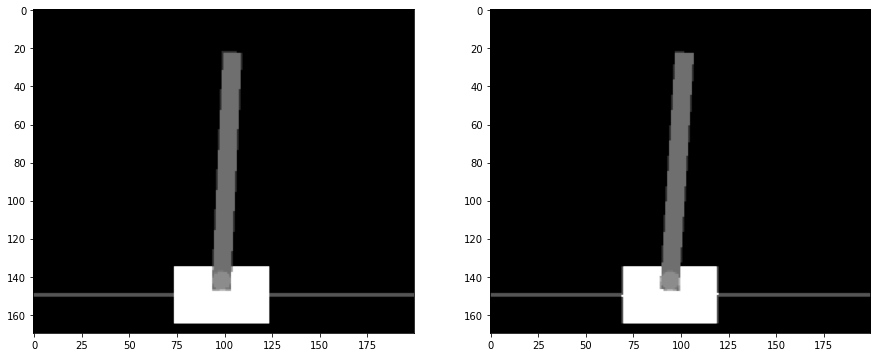

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for i in range(2):
    a = replay_mem.sample(1)
    screen = a[0][0][0]#.squeeze(0)#-a[1][0].squeeze(0)
    ax[i].imshow(screen, cmap='Greys')

plt.show()

In [15]:
def averaging(signal, freq=20):
    new_signal = []
    new_pos = []
    for i in range(len(signal)//freq):
        new_signal.append( signal[i*freq:(i+1)*freq].mean() )
        new_pos.append( (i*freq+(i+1)*freq)/2 )
        
    return new_pos, new_signal

def plot_profile_score( exploration_profile, training_score, freq=20,
                          figsize=(12, 8)):
    training_score = np.array(training_score)
    
    ### Plot exploration profile
    fig, ax1 = plt.subplots(figsize=figsize )

    color = 'crimson'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Exploration profile (Softmax temperature)', color=color)
    ax1.plot(exploration_profile, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    x, y = averaging(training_score, freq=freq)
    color = 'navy'
    ax2.set_ylabel('FINAL SCORE', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

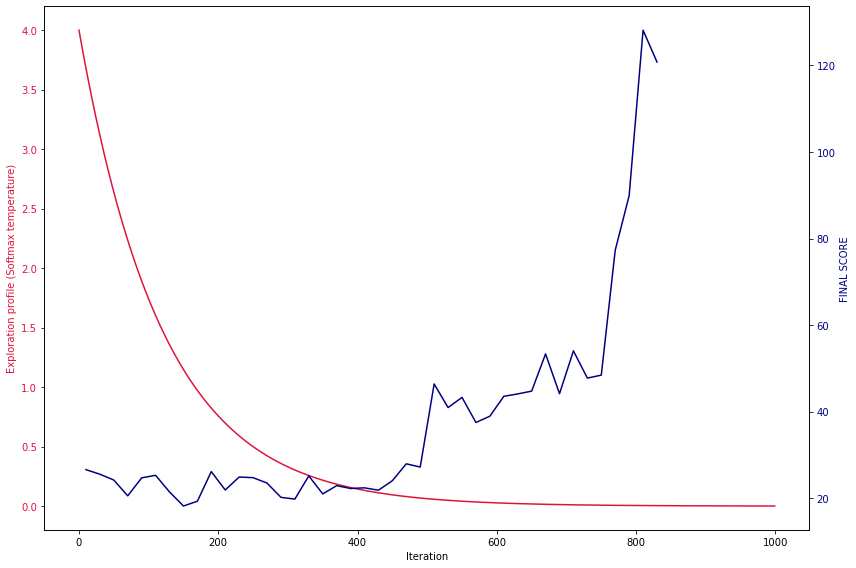

In [19]:
plot_profile_score( exploration_profile, training_score)

## Supervised part

In [7]:
# Pytorch lightning wrapper
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms

In [8]:
class SupDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = data

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = ( self.data[idx][0], self.data[idx][1] )
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor(x).float(),
                torch.tensor(y).float())

In [22]:
# Transformation to apply to data
composed_transform = transforms.Compose([ToTensor()])
# Dataset creation
dataset = SupDataset(training_dataset, transform=composed_transform)
N = len(training_dataset)

train_set = Subset(dataset, np.arange( int(0.7*N) ) )
val_set = Subset(dataset, np.arange( int(0.7*N), int(0.9*N) ) )
test_set = Subset(dataset, np.arange( int(0.9*N), N ) )

In [23]:
train_load = DataLoader(train_set, batch_size=20, 
                                    shuffle=True, num_workers=0 )
val_load = DataLoader(val_set, batch_size=20, 
                                    shuffle=False, num_workers=0 )
test_load = DataLoader(test_set, batch_size=20, 
                                    shuffle=False, num_workers=0 )

In [9]:
class Supervised(pl.LightningModule):

    def __init__(self):
        super().__init__()
    
        self.conv = nn.Sequential( 
                                    nn.Conv2d(4, 8, kernel_size=9, padding=0, stride=4), 
                                    nn.ReLU(),
                                    # Second convolutional layer
                                    nn.Conv2d(8, 16, kernel_size=6, padding=0, stride=4), 
                                    nn.ReLU(),
                                    # Third convolutional layer
                                    nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=4),
                                    nn.ReLU(),
                                    # Flatten layer
                                    nn.Flatten(start_dim=1),
                
                )
        
        self.linear = nn.Sequential(
                nn.Linear(288, 250),
                nn.Tanh(),
                nn.Linear(250, 128),
                nn.Tanh(),
                nn.Linear(128, 4)
                )
        
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = x.squeeze(1)
        x = self.conv(x)
        x = self.linear(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        x_hat = self.forward(x)
        loss = self.loss_fn(x_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        x_hat = self.forward(x)
        val_loss = self.loss_fn(x_hat, y)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, 
                                        weight_decay=1e-5)

        return optimizer
    
    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [25]:
### Set the random seed for reproducible results
torch.manual_seed(49)
np.random.seed(49)

supervised_train = Supervised()

### Define the loss function
loss_fn = torch.nn.MSELoss()
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
supervised_train.to(device)
supervised_train.configure_loss(loss_fn)

Selected device: cuda


In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=100, progress_bar_refresh_rate=20, 
                     callbacks=[EarlyStopping(monitor='validation_loss')])

trainer.fit(supervised_train, train_load, val_load)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | conv    | Sequential | 11.9 K
1 | linear  | Sequential | 104 K 
2 | loss_fn | MSELoss    | 0     
---------------------------------------
116 K     Trainable params
0         Non-trainable params
116 K     Total params


In [ ]:
trainer.test(supervised_train, test_load)

In [ ]:
#trainer.save_checkpoint("supervised.ckpt")

In [ ]:
for i in training_dataset[:10]:
    with torch.no_grad():
        pred = supervised_train.forward( torch.tensor(i[0]).unsqueeze(0).float().to(device) )
    print('Original \t \t \t \t \t ', 'Predicted')
    print(i[1], pred.cpu().numpy()[0])
    print('-----')

## Final training

In [10]:
class DQN(nn.Module):

    def __init__(self, supervised):
        super().__init__()
        
        self.super_conv = supervised.conv
        self.super_lin  = supervised.linear
        
        self.linear = nn.Sequential(
                nn.Linear(4, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, 2)
                )

    def forward(self, x):
        x = self.super_conv(x)
        x = self.super_lin(x)
        return self.linear(x)

In [11]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

supervised = Supervised.load_from_checkpoint("supervised.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
action_space_dim = 2

### PARAMETERS
gamma = 0.95   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 0.022   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training



### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(supervised).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(supervised).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [12]:
freeze = False

if freeze:
    # Freeze params in policy
    for param in policy_net.super_conv.parameters():
        param.requires_grad = False
    for param in policy_net.super_lin.parameters():
        param.requires_grad = False

    # Freeze params in target
    for param in target_net.super_conv.parameters():
        param.requires_grad = False
    for param in target_net.super_lin.parameters():
        param.requires_grad = False    

In [16]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

ml = 3

training_score = []
obs_history = deque(maxlen=ml)

for i in range(ml): obs_history.append(np.zeros((1, 170, 200) ))

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    # Reset the environment and get the initial state
    state = env.reset()
    obs = get_screen(env)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off
    for i in range(ml):
        obs = np.append( obs, obs_history[-i-1], axis=0)
    st = 0
    while not done:
        # Adding history
        for i in range(ml):
            if obs_history[i] is None: obs_history[i] = np.zeros((1, 170, 200) )
        #obs += 0.5*obs_history[0]
        obs_history.append(obs[0][np.newaxis, :])
        
        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, from_screen_to_tens(obs), temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_obs = get_screen(env)
        
        for i in range(ml):
            next_obs = np.append( next_obs, obs_history[-i-1], axis=0) 
        
        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1
        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_obs = None

        # Update the replay memory
        replay_mem.push(obs, action, next_obs, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Set the current state for the next iteration
        obs = next_obs
        state = next_state
        st += 1

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    training_score.append(score)
env.close()

<ipython-input-14-e7d6304cbb8e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 3.869105318455729
Updating target network...
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 3.7114939058851326
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 3.5603029

EPISODE: 120 - FINAL SCORE: 33 - Temperature: 1.4865829844310245
Updating target network...
EPISODE: 121 - FINAL SCORE: 84 - Temperature: 1.4742692172911107
EPISODE: 122 - FINAL SCORE: 20 - Temperature: 1.4620574484000428
EPISODE: 123 - FINAL SCORE: 18 - Temperature: 1.4499468328788614
EPISODE: 124 - FINAL SCORE: 24 - Temperature: 1.4379365328469669
EPISODE: 125 - FINAL SCORE: 21 - Temperature: 1.4260257173641504
Updating target network...
EPISODE: 126 - FINAL SCORE: 41 - Temperature: 1.4142135623731047
EPISODE: 127 - FINAL SCORE: 44 - Temperature: 1.4024992506424108
EPISODE: 128 - FINAL SCORE: 20 - Temperature: 1.3908819717099976
EPISODE: 129 - FINAL SCORE: 12 - Temperature: 1.3793609218270702
EPISODE: 130 - FINAL SCORE: 60 - Temperature: 1.3679353039025004
Updating target network...
EPISODE: 131 - FINAL SCORE: 19 - Temperature: 1.3566043274476813
EPISODE: 132 - FINAL SCORE: 14 - Temperature: 1.3453672085218358
EPISODE: 133 - FINAL SCORE: 8 - Temperature: 1.3342231696777787
EPISODE: 1

EPISODE: 237 - FINAL SCORE: 9 - Temperature: 0.5617499515158296
EPISODE: 238 - FINAL SCORE: 53 - Temperature: 0.5570968254096733
EPISODE: 239 - FINAL SCORE: 15 - Temperature: 0.5524822423999629
EPISODE: 240 - FINAL SCORE: 48 - Temperature: 0.5479058832238526
Updating target network...
EPISODE: 241 - FINAL SCORE: 36 - Temperature: 0.5433674312630361
EPISODE: 242 - FINAL SCORE: 12 - Temperature: 0.5388665725218424
EPISODE: 243 - FINAL SCORE: 62 - Temperature: 0.534402995605511
EPISODE: 244 - FINAL SCORE: 18 - Temperature: 0.5299763916986479
EPISODE: 245 - FINAL SCORE: 23 - Temperature: 0.5255864545438602
Updating target network...
EPISODE: 246 - FINAL SCORE: 21 - Temperature: 0.5212328804205676
EPISODE: 247 - FINAL SCORE: 26 - Temperature: 0.5169153681239891
EPISODE: 248 - FINAL SCORE: 20 - Temperature: 0.5126336189443038
EPISODE: 249 - FINAL SCORE: 34 - Temperature: 0.5083873366459849
EPISODE: 250 - FINAL SCORE: 34 - Temperature: 0.5041762274473043
Updating target network...
EPISODE: 25

EPISODE: 353 - FINAL SCORE: 82 - Temperature: 0.2140470711366183
EPISODE: 354 - FINAL SCORE: 64 - Temperature: 0.212274061611714
EPISODE: 355 - FINAL SCORE: 22 - Temperature: 0.21051573840210802
Updating target network...
EPISODE: 356 - FINAL SCORE: 34 - Temperature: 0.20877197985709636
EPISODE: 357 - FINAL SCORE: 46 - Temperature: 0.2070426653336404
EPISODE: 358 - FINAL SCORE: 50 - Temperature: 0.20532767518802042
EPISODE: 359 - FINAL SCORE: 10 - Temperature: 0.20362689076755777
EPISODE: 360 - FINAL SCORE: 61 - Temperature: 0.20194019440240596
Updating target network...
EPISODE: 361 - FINAL SCORE: 72 - Temperature: 0.20026746939740941
EPISODE: 362 - FINAL SCORE: 52 - Temperature: 0.19860860002403005
EPISODE: 363 - FINAL SCORE: 59 - Temperature: 0.1969634715123404
EPISODE: 364 - FINAL SCORE: 64 - Temperature: 0.19533197004308317
EPISODE: 365 - FINAL SCORE: 24 - Temperature: 0.19371398273979668
Updating target network...
EPISODE: 366 - FINAL SCORE: 19 - Temperature: 0.19210939766100535


EPISODE: 469 - FINAL SCORE: 52 - Temperature: 0.08155968423056191
EPISODE: 470 - FINAL SCORE: 23 - Temperature: 0.08088410340518039
Updating target network...
EPISODE: 471 - FINAL SCORE: 63 - Temperature: 0.08021411859768356
EPISODE: 472 - FINAL SCORE: 92 - Temperature: 0.07954968345474846
EPISODE: 473 - FINAL SCORE: 64 - Temperature: 0.07889075200700923
EPISODE: 474 - FINAL SCORE: 58 - Temperature: 0.07823727866587665
EPISODE: 475 - FINAL SCORE: 23 - Temperature: 0.077589218220384
Updating target network...
EPISODE: 476 - FINAL SCORE: 73 - Temperature: 0.07694652583405924
EPISODE: 477 - FINAL SCORE: 54 - Temperature: 0.07630915704182285
EPISODE: 478 - FINAL SCORE: 70 - Temperature: 0.07567706774691157
EPISODE: 479 - FINAL SCORE: 15 - Temperature: 0.07505021421782748
EPISODE: 480 - FINAL SCORE: 31 - Temperature: 0.07442855308531245
Updating target network...
EPISODE: 481 - FINAL SCORE: 90 - Temperature: 0.07381204133934757
EPISODE: 482 - FINAL SCORE: 45 - Temperature: 0.073200636326177

EPISODE: 584 - FINAL SCORE: 67 - Temperature: 0.031336763621909666
EPISODE: 585 - FINAL SCORE: 78 - Temperature: 0.03107719277103893
Updating target network...
EPISODE: 586 - FINAL SCORE: 27 - Temperature: 0.03081977201541845
EPISODE: 587 - FINAL SCORE: 67 - Temperature: 0.030564483545230323
EPISODE: 588 - FINAL SCORE: 17 - Temperature: 0.030311309698180175
EPISODE: 589 - FINAL SCORE: 56 - Temperature: 0.030060232958275167
EPISODE: 590 - FINAL SCORE: 45 - Temperature: 0.02981123595461214
Updating target network...
EPISODE: 591 - FINAL SCORE: 92 - Temperature: 0.029564301460175815
EPISODE: 592 - FINAL SCORE: 31 - Temperature: 0.02931941239064691
EPISODE: 593 - FINAL SCORE: 96 - Temperature: 0.02907655180322016
EPISODE: 594 - FINAL SCORE: 64 - Temperature: 0.028835702895432122
EPISODE: 595 - FINAL SCORE: 52 - Temperature: 0.02859684900399868
Updating target network...
EPISODE: 596 - FINAL SCORE: 21 - Temperature: 0.02835997360366219
EPISODE: 597 - FINAL SCORE: 11 - Temperature: 0.0281250

EPISODE: 697 - FINAL SCORE: 153 - Temperature: 0.01224214354608391
EPISODE: 698 - FINAL SCORE: 12 - Temperature: 0.01214073857475123
EPISODE: 699 - FINAL SCORE: 22 - Temperature: 0.012040173568100576
EPISODE: 700 - FINAL SCORE: 99 - Temperature: 0.011940441568478316
Updating target network...
EPISODE: 701 - FINAL SCORE: 48 - Temperature: 0.011841535675862934
EPISODE: 702 - FINAL SCORE: 82 - Temperature: 0.011743449047387654
EPISODE: 703 - FINAL SCORE: 19 - Temperature: 0.011646174896867008
EPISODE: 704 - FINAL SCORE: 44 - Temperature: 0.011549706494327329
EPISODE: 705 - FINAL SCORE: 168 - Temperature: 0.011454037165541133
Updating target network...
EPISODE: 706 - FINAL SCORE: 79 - Temperature: 0.011359160291565359
EPISODE: 707 - FINAL SCORE: 161 - Temperature: 0.011265069308283436
EPISODE: 708 - FINAL SCORE: 11 - Temperature: 0.011171757705951135
EPISODE: 709 - FINAL SCORE: 46 - Temperature: 0.011079219028746196
EPISODE: 710 - FINAL SCORE: 41 - Temperature: 0.010987446874321665
Updatin

EPISODE: 810 - FINAL SCORE: 147 - Temperature: 0.004782564032813508
Updating target network...
EPISODE: 811 - FINAL SCORE: 58 - Temperature: 0.0047429487671683595
EPISODE: 812 - FINAL SCORE: 61 - Temperature: 0.004703661645435424
EPISODE: 813 - FINAL SCORE: 45 - Temperature: 0.00466469994951032
EPISODE: 814 - FINAL SCORE: 59 - Temperature: 0.004626060983803456
EPISODE: 815 - FINAL SCORE: 281 - Temperature: 0.004587742075053536
Updating target network...
EPISODE: 816 - FINAL SCORE: 62 - Temperature: 0.004549740572142606
EPISODE: 817 - FINAL SCORE: 122 - Temperature: 0.004512053845912637
EPISODE: 818 - FINAL SCORE: 23 - Temperature: 0.004474679288983623
EPISODE: 819 - FINAL SCORE: 254 - Temperature: 0.004437614315573189
EPISODE: 820 - FINAL SCORE: 87 - Temperature: 0.004400856361317693
Updating target network...
EPISODE: 821 - FINAL SCORE: 33 - Temperature: 0.004364402883094803
EPISODE: 822 - FINAL SCORE: 28 - Temperature: 0.004328251358847559
EPISODE: 823 - FINAL SCORE: 40 - Temperature

EPISODE: 922 - FINAL SCORE: 21 - Temperature: 0.001883980829265989
EPISODE: 923 - FINAL SCORE: 211 - Temperature: 0.0018683753087732852
EPISODE: 924 - FINAL SCORE: 39 - Temperature: 0.0018528990530087917
EPISODE: 925 - FINAL SCORE: 80 - Temperature: 0.0018375509912379583
Updating target network...
EPISODE: 926 - FINAL SCORE: 131 - Temperature: 0.0018223300615954183
EPISODE: 927 - FINAL SCORE: 54 - Temperature: 0.0018072352110115207
EPISODE: 928 - FINAL SCORE: 27 - Temperature: 0.0017922653951394749
EPISODE: 929 - FINAL SCORE: 48 - Temperature: 0.0017774195782830954
EPISODE: 930 - FINAL SCORE: 295 - Temperature: 0.0017626967333251471
Updating target network...
EPISODE: 931 - FINAL SCORE: 434 - Temperature: 0.001748095841656284
EPISODE: 932 - FINAL SCORE: 185 - Temperature: 0.0017336158931045753
EPISODE: 933 - FINAL SCORE: 117 - Temperature: 0.0017192558858656157
EPISODE: 934 - FINAL SCORE: 47 - Temperature: 0.0017050148264332167
EPISODE: 935 - FINAL SCORE: 70 - Temperature: 0.0016908917

Exception ignored in: <function Viewer.__del__ at 0x000002060D295310>
Traceback (most recent call last):
  File "C:\Users\win10\anaconda3\envs\Pytorch\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\win10\anaconda3\envs\Pytorch\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\win10\anaconda3\envs\Pytorch\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\win10\anaconda3\envs\Pytorch\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\win10\anaconda3\envs\Pytorch\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000002060D293A40; to 'Win32Window' at 0x0000020604124F70>


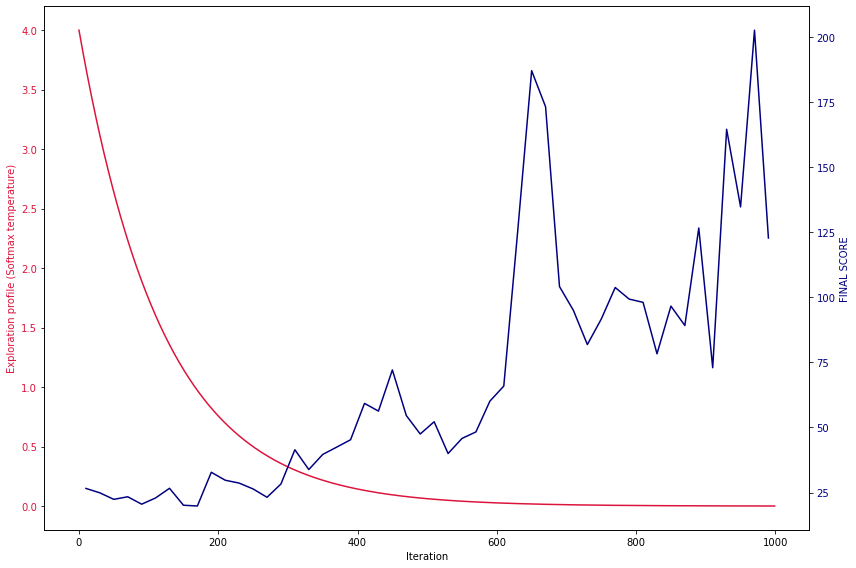

In [17]:
plot_profile_score( exploration_profile, training_score)

In [18]:
torch.save(policy_net.state_dict(), 'pixel_model')

## Final test

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
p =  Supervised()
policy_net = DQN(p)
policy_net.load_state_dict(torch.load('pixel_model'))
policy_net.to(device)

DQN(
  (super_conv): Sequential(
    (0): Conv2d(4, 8, kernel_size=(9, 9), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(6, 6), stride=(4, 4))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (super_lin): Sequential(
    (0): Linear(in_features=288, out_features=250, bias=True)
    (1): Tanh()
    (2): Linear(in_features=250, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [22]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
ml = 3
env.seed(49) # Set a random seed for the environment (reproducible results)
obs_history = deque(maxlen=ml)
for i in range(ml): obs_history.append(np.zeros((1, 170, 200) ))


# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    obs = get_screen(env)
    
    for i in range(ml):
        obs = np.append( obs, obs_history[-i-1], axis=0)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, from_screen_to_tens(obs), temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

<ipython-input-3-c7dc4a75c73c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor


EPISODE 1 - FINAL SCORE: 10.0
EPISODE 2 - FINAL SCORE: 10.0
EPISODE 3 - FINAL SCORE: 9.0
EPISODE 4 - FINAL SCORE: 9.0
EPISODE 5 - FINAL SCORE: 9.0
EPISODE 6 - FINAL SCORE: 10.0
EPISODE 7 - FINAL SCORE: 10.0
EPISODE 8 - FINAL SCORE: 9.0
EPISODE 9 - FINAL SCORE: 8.0
EPISODE 10 - FINAL SCORE: 10.0
